In [1]:
import numpy as np
import numba
from numba import njit, jit
import matplotlib.pyplot as plt
from probDE.car import car_init
from probDE.ibm import ibm_init
from probDE.utils.utils import rand_mat, indep_init, zero_pad
from scipy.integrate import odeint
from probDE.cython.KalmanODE import KalmanODE as KalmanODE_blas
from kalmanode_numba import KalmanODE as KalmanODE_num
from probDE.tests.KalmanODE import KalmanODE
from KalmanODE_py import KalmanODE_py
%load_ext Cython

In [33]:
%%cython
from libc.math cimport sin
cpdef ode_fun(double[::1] x, double t, tuple theta, double[::1] x_out):
    x_out[0] = sin(2*t) - x[0]
    return


In [3]:
import numba
from math import sin

@njit
def ode_fun2(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = np.zeros(1)
    x_out[0] = sin(2*t) - x[0]
    return x_out

def ode_fun3(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = np.zeros(1)
    x_out[0] = sin(2*t) - x[0]
    return

@njit
def f(x_t, t):
    return [x_t[1], sin(2*t) - x_t[0]]

In [4]:
# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]], order='F')

# These parameters define the order of the ODE and the CAR(p) process
n_obs = 1
n_deriv = [3]
n_deriv_prior = [4]
p = sum(n_deriv_prior)

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 80
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = [.5]

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(x0, n_deriv, n_deriv_prior)
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

In [5]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, ode_fun3, **kinit)
kalmanode.z_states = z_states
kalman_sim = kalmanode.solve(x0_state, W)

In [6]:
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, ode_fun3, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
k_sim = kalmanode_py.solve(x0_state, W)

In [7]:
kalmanode = KalmanODE(p, n_obs, tmin, tmax, n_eval, ode_fun3, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_sim = kalmanode.solve(x0_state, W)

In [8]:
kode_num = KalmanODE_num(p, n_obs, tmin, tmax, n_eval, ode_fun2, kinit['mu_state'], 
                         kinit['wgt_state'], kinit['var_state'], z_states)
kk_sim, _ = kode_num.solve(x0_state, W, np.empty(0, order='F'))

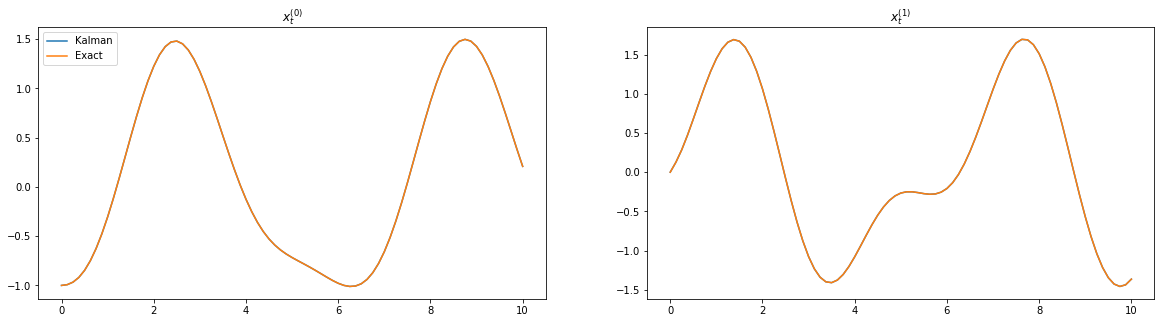

In [9]:
# ode function in odeint format
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = odeint(f, [-1, 0], tseq)
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].plot(tseq, kalman_sim[:,0], label = 'Kalman')
axs[0].plot(tseq, k_sim[:, 0], label = 'Exact')
axs[0].set_title("$x^{(0)}_t$")
axs[0].legend(loc='upper left')
axs[1].plot(tseq, kalman_sim[:,1], label = 'Kalman')
axs[1].plot(tseq, k_sim[:, 1], label = 'Exact')
axs[1].set_title("$x^{(1)}_t$")
plt.show()

In [10]:
kalmanode = KalmanODE(p, n_obs, tmin, tmax, n_eval, ode_fun3, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_c = %timeit -o _ = kalmanode.solve(x0_state, W)

358 µs ± 5.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, ode_fun3, **kinit) # Initialize the class
kalmanode.z_states = z_states
kalman_cy = %timeit -o _ = kalmanode.solve(x0_state, W)

1.14 ms ± 10.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [12]:
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, ode_fun, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_py = %timeit -o _ = kalmanode_py.solve(x0_state, W)

9.67 ms ± 433 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
kalman_numba = %timeit -o _ = kode_num.solve(x0_state, W, np.empty(0))

829 µs ± 19.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [14]:
tseq = np.linspace(tmin, tmax, n_eval+1)
ode = %timeit -o _ = odeint(f, [-1, 0], tseq)

411 µs ± 4.99 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [15]:
print("Cython is {}x faster than Python".format(kalman_py.average/kalman_cy.average))
print("Numba is {}x faster than Python".format(kalman_py.average/kalman_numba.average))
print("C++ is {}x faster than Python".format(kalman_py.average/kalman_c.average))
print("ode is {}x faster than Python".format(kalman_py.average/ode.average))

Cython is 8.492260260164057x faster than Python
Numba is 11.673087771377975x faster than Python
C++ is 27.055436441023947x faster than Python
ode is 23.53598340156126x faster than Python


## Lorenz63

In [11]:
%%cython
# RHS of ODE
import numpy as np
cimport numpy as np
cpdef lorenz(double[::1] X, double t, double[::1] theta, out):
    rho, sigma, beta = theta[:]
    cdef int p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[0] = -sigma*x + sigma*y
    out[1] = rho*x - y -x*z
    out[2] = -beta*z + x*y
    return

In [3]:
@njit
def lorenz0(X, t, theta, out=None):
    if out is None:
        out = np.zeros(3)
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[:] = -sigma*x + sigma*y, rho*x - y -x*z, -beta*z + x*y
    return out

In [12]:
# These parameters define the order of the ODE and the CAR(p) process
n_obs = 3
n_deriv = [2, 2, 2] # number of continuous derivatives of CAR(p) solution prior
n_deriv_prior = [3, 3, 3]
p = sum(n_deriv_prior)

# LHS Matrix of ODE
W_mat = np.zeros((len(n_deriv), sum(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+1] = 1

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 3000
tmin = 0
tmax = 20
theta = np.array([28, 10, 8/3])

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
X0 = np.array([-12, 70, -5, 125, 38, -124/3])

In [13]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
W = zero_pad(W_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit)
# Run the solver to get an approximation
kalman_lor_sim = kalmanode.solve(x0_state, W, theta)

In [24]:
z_state = rand_mat(2*(n_eval+1), p)
kode_num = KalmanODE_num(p, n_obs, tmin, tmax, n_eval, lorenz0, kinit['mu_state'], 
                                 kinit['wgt_state'], kinit['var_state'], z_state)

knum_sim, _ = kode_num.solve(x0_state, W, theta)

In [7]:
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_lorenz = odeint(lorenz0, x0, tseq, args=(theta,))

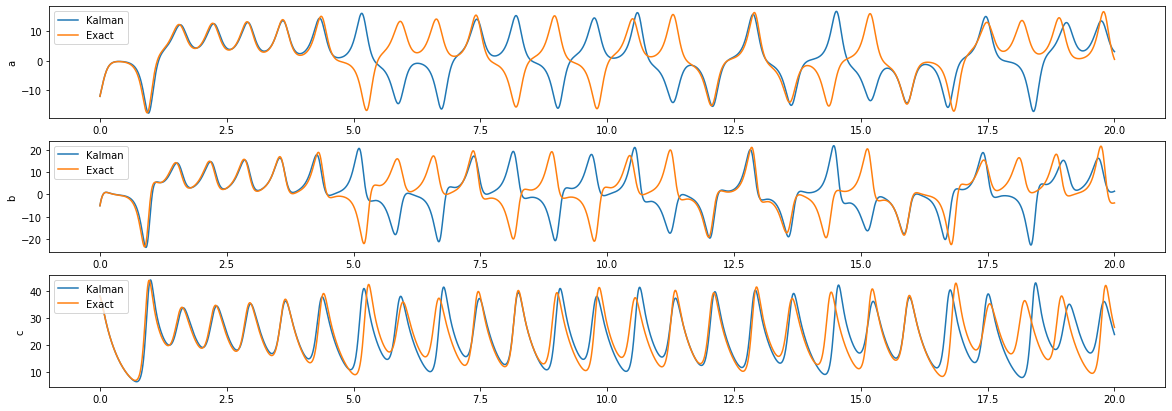

In [14]:
_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq, kalman_lor_sim[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, ode_lorenz[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [7]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_lor_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta)
kalmanode_c = KalmanODE(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_lor_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, lorenz, **kinit)
kalmanode.z_states = z_states
kalman_lor_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta)
#kalman_lor_num = %timeit -o _ = kode_num.solve(x0_state, W, theta, True)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_lorenz = %timeit -o ode = odeint(lorenz0, x0, tseq, args=(theta,))
print('py/cy: {}'.format(kalman_lor_py.average/kalman_lor_cy.average))
#print('py/numba: {}'.format(kalman_lor_py.average/kalman_lor_num.average))
print('py/c: {}'.format(kalman_lor_py.average/kalman_lor_c.average))
print('py/ode: {}'.format(kalman_lor_py.average/ode_lorenz.average))

398 ms ± 21.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
31.3 ms ± 587 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.8 ms ± 659 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
8.02 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
py/cy: 11.771297750432886
py/c: 12.734832850855412
py/ode: 49.62324065349933


# Fitz model

In [32]:
%%cython
cpdef fitz(double[::1] X, double t, double[::1] theta, double[::1] X_out):
    "FitzHugh-Nagumo ODE function."
    a, b, c = theta
    cdef int n_deriv1 = len(X)//2
    V, R = X[0], X[n_deriv1]
    X_out[0] = c*(V - V**3/3 + R)
    X_out[1] = -1/c*(V - a + b*R)
    return

In [31]:
@njit
def fitz0(X, t, theta, out=None):
    "FitzHugh-Nagumo ODE function."
    if out is None:
        out = np.zeros(2)
    a, b, c = theta
    n_deriv1 = len(X)//2
    V, R = X[0], X[n_deriv1]
    out[:] = c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)
    return out

In [29]:
n_deriv = [2, 2] # Total state
n_deriv_prior = [3, 3]
p = sum(n_deriv_prior)
n_obs = 2 # Total measures

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0 
tmax = 40
#h = 0.1 # step size
#n_eval = int((tmax-tmin)/h)
n_eval = 400

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
sigma = [.1]*n_var

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
X0 = np.array([-1, 1, 1, 1/3])
w_mat = np.array([[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
theta = np.array([0.2, 0.2, 3])


In [33]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, fitz, **kinit)
z_states = rand_mat(2*(n_eval+1), p)
kalmanode.z_states = z_states
# Run the solver to get an approximation
kalman_fitz_sim = kalmanode.solve(x0_state, W, theta)

In [28]:
z_state = rand_mat(2*(n_eval+1), p)
kode_num = KalmanODE_num(p, n_obs, tmin, tmax, n_eval, fitz0, kinit['mu_state'], 
                                 kinit['wgt_state'], kinit['var_state'], z_state)

knum_sim = kode_num.solve(x0_state, W, theta)

In [ ]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(fitz0, x0, tseq, args=(theta,))

_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['a', 'b', 'c']
for i in range(n_obs):
    axs[i].plot(tseq, knum_sim[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [12]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode_c = KalmanODE(p, n_obs, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_fitz_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, fitz, **kinit)
kalmanode.z_states = z_states
kalman_fitz_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta)
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, fitz, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_fitz_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta)
#kalman_fitz_num = %timeit -o _ = kode_num.solve(x0_state, W, theta)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_fitz = %timeit -o ode =  odeint(fitz0, x0, tseq, args=(theta,))
print('py/cy: {}'.format(kalman_fitz_py.average/kalman_fitz_cy.average))
#print('py/num: {}'.format(kalman_fitz_py.average/kalman_fitz_num.average))
print('py/c: {}'.format(kalman_fitz_py.average/kalman_fitz_c.average))
print('py/ode: {}'.format(kalman_fitz_py.average/ode_fitz.average))

2.81 ms ± 31.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
3.42 ms ± 87.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
52 ms ± 2.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.86 ms ± 107 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
py/cy: 15.203793374337293
py/c: 18.496313215774165
py/ode: 13.456419500532453


# MSEIR model

We will look at a multivariate ODE system called **MSEIR model**. This model is used in epidemiology where<br/>
M = Maternally-derived Immunity<br/>
S = Susceptible<br/>
E = Exposed<br/>
I = Infectious<br/>
R = Recovered<br/>

\begin{equation}
  \begin{aligned}
    \frac{dM}{dt} &= \Lambda - \delta M - \mu M \\
    \frac{dS}{dt} &= \delta M- \frac{\beta SI}{N} - \mu S \\
    \frac{dE}{dt} &= \frac{\beta SI}{N} - (\epsilon + \mu)E \\
    \frac{dI}{dt} &= \epsilon E - (\gamma + \mu)I \\
    \frac{dR}{dt} &= \gamma I - \mu R
  \end{aligned}
\end{equation}


In [34]:
%%cython
import numpy as np
cimport numpy as np
cpdef mseir(double[::1] X, double t, double[::1] theta, double[::1] X_out):
    cdef int p = len(X)//5
    M, S, E, I, R = X[::p]
    cdef double N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    X_out[0] = Lambda - delta*M - mu*M
    X_out[1] = delta*M - beta*S*I/N - mu*S
    X_out[2] = beta*S*I/N - (epsilon + mu)*E
    X_out[3] = epsilon*E - (gamma + mu)*I
    X_out[4] = gamma*I - mu*R
    return

In [26]:
@njit
def mseir0(X_t, t, theta, out=None):
    "MSEIR ODE function"
    if out is None:
        out = np.zeros(5)
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    dM = Lambda - delta*M - mu*M
    dS = delta*M - beta*S*I/N - mu*S
    dE = beta*S*I/N - (epsilon + mu)*E
    dI = epsilon*E - (gamma + mu)*I
    dR = gamma*I - mu*R
    out[:] = np.array([dM, dS, dE, dI, dR])
    return out

In [35]:
# LHS Matrix of ODE

n_deriv = [2]*5 # Total state
n_deriv_prior = [3]*5
p = sum(n_deriv_prior)
n_obs = 5 # Total measures
state_ind = [0, 3, 6, 9, 12]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 50
tmin = 0
tmax = 20
theta = np.array([1.1, 0.7, 0.4, 0.005, 0.02, 0.03])

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 5
sigma = [.1]*n_var

# Initial value, x0, for the IVP
W_mat = np.zeros((len(n_deriv), sum(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

x0 = np.array([1000, 100, 50, 3, 3])
v0 = mseir0(x0, 0, theta)
X0 = np.ravel([x0, v0], 'F')
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)

In [36]:
# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# Initialize CAR with three variables
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# Initialize the Kalman class
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, mseir, **kinit)
# Run the solver to get an approximation
kalman_mse_sim = kalmanode.solve(x0_state, W, theta)

In [ ]:
z_state = rand_mat(2*(n_eval+1), p)
kode_num = KalmanODE_num(p, n_obs, tmin, tmax, n_eval, mseir0, kinit['mu_state'], 
                         kinit['wgt_state'], kinit['var_state'], z_state)

knum_sim = kode_num.solve(x0_state, W, theta)

In [ ]:
tseq = np.linspace(tmin, tmax, n_eval+1)
exact = odeint(mseir0, x0, tseq, args=(theta,))

_, axs = plt.subplots(n_obs, 1, figsize=(20, 7))
ylabel = ['M', 'S', 'E', 'I', 'R']
for i in range(n_obs):
    axs[i].plot(tseq, knum_sim[:, n_deriv_prior[0]*i], label="Kalman")
    axs[i].set_ylabel(ylabel[i])
    axs[i].plot(tseq, exact[:, i], label='Exact')
    axs[i].legend(loc='upper left')

In [18]:
z_states = rand_mat(2*(n_eval+1), p)
kalmanode_c = KalmanODE(p, n_obs, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_c.z_states = z_states
kalman_mse_c = %timeit -o _ = kalmanode_c.solve(x0_state, W, theta)
kalmanode = KalmanODE_blas(p, n_obs, tmin, tmax, n_eval, mseir, **kinit)
kalmanode.z_states = z_states
kalman_mse_cy = %timeit -o _ = kalmanode.solve(x0_state, W, theta)
kalmanode_py = KalmanODE_py(p, n_obs, tmin, tmax, n_eval, mseir, **kinit) # Initialize the class
kalmanode_py.z_states = z_states
kalman_mse_py = %timeit -o _ = kalmanode_py.solve(x0_state, W, theta)
#kalman_mse_num = %timeit -o _ = kode_num.solve(x0_state, W, theta)
tseq = np.linspace(tmin, tmax, n_eval+1)
ode_mseir = %timeit -o ode =  odeint(mseir0, x0, tseq, args=(theta,))
print('py/cy: {}'.format(kalman_mse_py.average/kalman_mse_cy.average))
#print('py/num: {}'.format(kalman_mse_py.average/kalman_mse_num.average))
print('py/c: {}'.format(kalman_mse_py.average/kalman_mse_c.average))
print('py/ode: {}'.format(kalman_mse_py.average/ode_mseir.average))

1.21 ms ± 3.24 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.33 ms ± 4.87 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
7.36 ms ± 173 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
376 µs ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
py/cy: 5.535018231613893
py/c: 6.0988920622277325
py/ode: 19.558309737042777
